<a href="https://www.kaggle.com/code/sarvagyaporwal/storesales-1-eda-boostedhybridmodelling?scriptVersionId=152445216" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error ,mean_squared_error

import math

# graphs
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# time
import calendar

# SARIMA
from typing import Union
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit


# stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm as tqdm_notebook
from statsmodels.stats.diagnostic import acorr_ljungbox


# Data

**Key FACTS**

**HORIZON :** 15 days after the last date in the training data.

**OIL :**  Includes values during both the train and test data timeframes.

**HOLIDAY :** date, type, locale, locale_name, description, transferred
        
   ---> **Type Bridge :** extra days added to holiday (e.g., to extend the break across a long weekend).
   
   ---> **Type Additional :** days added a regular calendar holiday, for example, as typically happens around Christmas
   
**Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month.**

**A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake**

In [2]:
# files
train = pd.read_csv("../input/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("../input/store-sales-time-series-forecasting/test.csv")
stores = pd.read_csv("../input/store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("../input/store-sales-time-series-forecasting/transactions.csv").sort_values(["store_nbr", "date"])
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')  # has missing
holiday = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

df_data = pd.concat([train, test])
df_data = df_data.merge(stores, how="left", on='store_nbr')   
df_data = df_data.merge(oil, how="left", on='date')      
df_data = df_data.merge(transactions, how="left", on=['date','store_nbr'])  
df_data = df_data.merge(holiday,on='date',how='left')
df_data = df_data.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

df_data.date = pd.to_datetime(df_data.date)
df_data.head()

id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  store_type  cluster  dcoilwtico  transactions holiday_type    locale  \
0          D       13         NaN           NaN      Holiday  National   
1          D       13         NaN           NaN      Holiday  National   
2          D       13         NaN           NaN      Holiday  National   
3          D       13         NaN           NaN      Holiday  National   
4          D       13         NaN           NaN      Holiday  National   

  locale_name         description transferred  
0     Ecuador  Primer dia del ano       False  
1     Ecuador  Primer dia del ano       False  
2     Ecuador  Primer dia del ano       False  
3     Ecuador  Primer dia del ano       False  
4     Ecuador  Primer dia del ano       False

# Oil Price Analysis

In [3]:
# merging oil with train
if np.isnan(df_data.dcoilwtico.iloc[0]):
    df_data.loc[0,'dcoilwtico'] = df_data.loc[df_data['dcoilwtico'].first_valid_index(),'dcoilwtico']  # update with recent non-nan value

df_data['dcoilwtico'] = df_data['dcoilwtico'].interpolate(limit_direction='forward')   #  Filling missing (4%) of 'oil' using linear interpolation
df_data.describe()

id                           date     store_nbr  \
count  3.082860e+06                        3082860  3.082860e+06   
mean   1.518250e+06  2015-05-04 08:51:53.063583488  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.618048e+05            2014-03-05 00:00:00  1.400000e+01   
50%    1.521828e+06            2015-05-06 12:00:00  2.750000e+01   
75%    2.272940e+06            2016-07-02 00:00:00  4.100000e+01   
max    3.029399e+06            2017-08-31 00:00:00  5.400000e+01   
std    8.742912e+05                            NaN  1.558579e+01   

              sales   onpromotion       cluster    dcoilwtico  transactions  
count  3.054348e+06  3.082860e+06  3.082860e+06  3.082860e+06  2.805231e+06  
mean   3.590209e+02  2.657692e+00  8.481481e+00  6.763488e+01  1.697071e+03  
min    0.000000e+00  0.000000e+00  1.000000e+00  2.619000e+01  5.000000e+00  
25%    0.000000e+00  0.000000e+00  4.000000e+00  4.637000e+01  1.046000e+03  
50%    1.100000e+01  0.000000e+00  8.500000e+00  5.318834e+01  1.395000e+03  
75%    1.960110e+02  0.000000e+00  1.300000e+01  9.566091e+01  2.081000e+03  
max    1.247170e+05  7.410000e+02  1.700000e+01  1.106200e+02  8.359000e+03  
std    1.107286e+03  1.236626e+01  4.649735e+00  2.563779e+01  9.668317e+02

* As train data contains 3M+ points , hence plotting oil.csv(not train data) which contains ~1200 points

In [4]:
# moving average
moving_average_oil = oil.dcoilwtico.rolling(
    window=30,       # 1-month window
    min_periods=1,    # atleast 1 needed to evaluate window mean
).mean()              # compute the mean (could also do median, std, min, max, ...)


# Plotting
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.08,                    
                    subplot_titles=("Oil price during time"))
fig.add_trace(go.Scatter(x=oil.date, y=oil.dcoilwtico, mode='lines', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Oil price'), 
                     row=1, col=1)
fig.add_trace(go.Scatter(x=oil.date,y=moving_average_oil ,mode='lines',name='Trend'))

fig.update_layout(height=350, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Oil price trend during time",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

**The plot of oil is broken at many points this is due to presence of nan, but we can observe a wide picture of oil price**

**Observations:**

* The price dropped over the years, with strong decreasing trend (Jul-2014 to March-2015)

# Analysing Holidays

* **Bridge Day** is a holiday that is made even longer by taking a day off on a nearby weekday. 

* This can create a long weekend or even a week-long vacation. 

* However, since Bridge Days are often taken from normal workdays, they need to be paid back by working on a day that is not normally scheduled for work, such as a Saturday.(**Work Day**)

* Assuming that the missing data corresponding to this DataFrame in the training set correspond to those days for which no public holiday has been recorded. 

* Therefore, we will replace the type by **Working_Day**. The rest of the categorical variables in this DataFrame will be changed to the empty string, and in **transferred** we will set all values to false.

In [5]:
print('@ shape : ' , holiday.shape)
print('@ type : ' ,holiday.type.unique())
print('@ locale : ' ,holiday.locale.unique())
print('@ locale_name : ' ,holiday.locale_name.unique())
print('@ unique_descriptions : ' ,len(holiday.description.unique()))
holiday.head(2)

@ shape :  (350, 6)
@ type :  ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
@ locale :  ['Local' 'Regional' 'National']
@ locale_name :  ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']
@ unique_descriptions :  103


date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   

   transferred  
0        False  
1        False

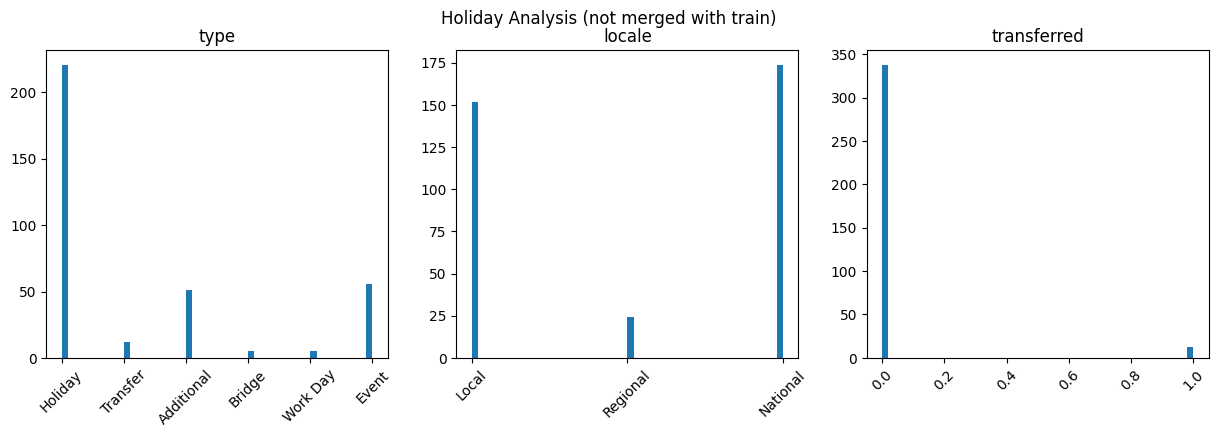

In [6]:
def f(x):
    if x:
        return 1
    return 0

holiday['transferred'] = holiday['transferred'].apply(lambda x: f(x))

# Plotting Histograms for holiday analysis
fig, axs = plt.subplots(1,3, figsize=(15,4))
arr = ['type','locale','transferred']
fig.suptitle('Holiday Analysis (not merged with train)')
for i in range(len(arr)):
    axs[i].set_title(arr[i])
    axs[i].hist(holiday[arr[i]], bins = 50)
    axs[i].tick_params(axis ='x', rotation=45)
plt.show()

* We can neglect the effect of Holiday transfer on our sales by looking at plot 3
* Currently not implementing this idea but will later touch upon this while doing feature selection

In [7]:
df_data[['locale','locale_name', 'description']] = df_data[['locale','locale_name', 'description']].replace(np.nan,'')
df_data['holiday_type'] = df_data['holiday_type'].replace(np.nan,'Working_Day')
df_data['transferred'] = df_data['transferred'].replace(np.nan,False)

df_data.head(2)

id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   

  store_type  cluster  dcoilwtico  transactions holiday_type    locale  \
0          D       13       93.14           NaN      Holiday  National   
1          D       13       93.14           NaN      Holiday  National   

  locale_name         description  transferred  
0     Ecuador  Primer dia del ano        False  
1     Ecuador  Primer dia del ano        False

# Analysing Stores

In [8]:
print('@ str_nbr : ', stores.store_nbr.unique(),end = '\n\n')
print('@ city : ' , stores.city.unique() , end ='\n\n')
print('@ state : ' , stores.state.unique() , end='\n\n')
print('@ type : ',stores.type.unique() , end='\n\n')
print('@ cluster : ' , stores.cluster.sort_values().unique())

@ str_nbr :  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]

@ city :  ['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']

@ state :  ['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']

@ type :  ['D' 'B' 'C' 'E' 'A']

@ cluster :  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [9]:
def f(x):
    if x=='A':
        return 0
    elif x=='B':
        return 1
    elif x=='C':
        return 2
    else :
        return 3

stores['type'] = stores['type'].apply(lambda x: f(x))

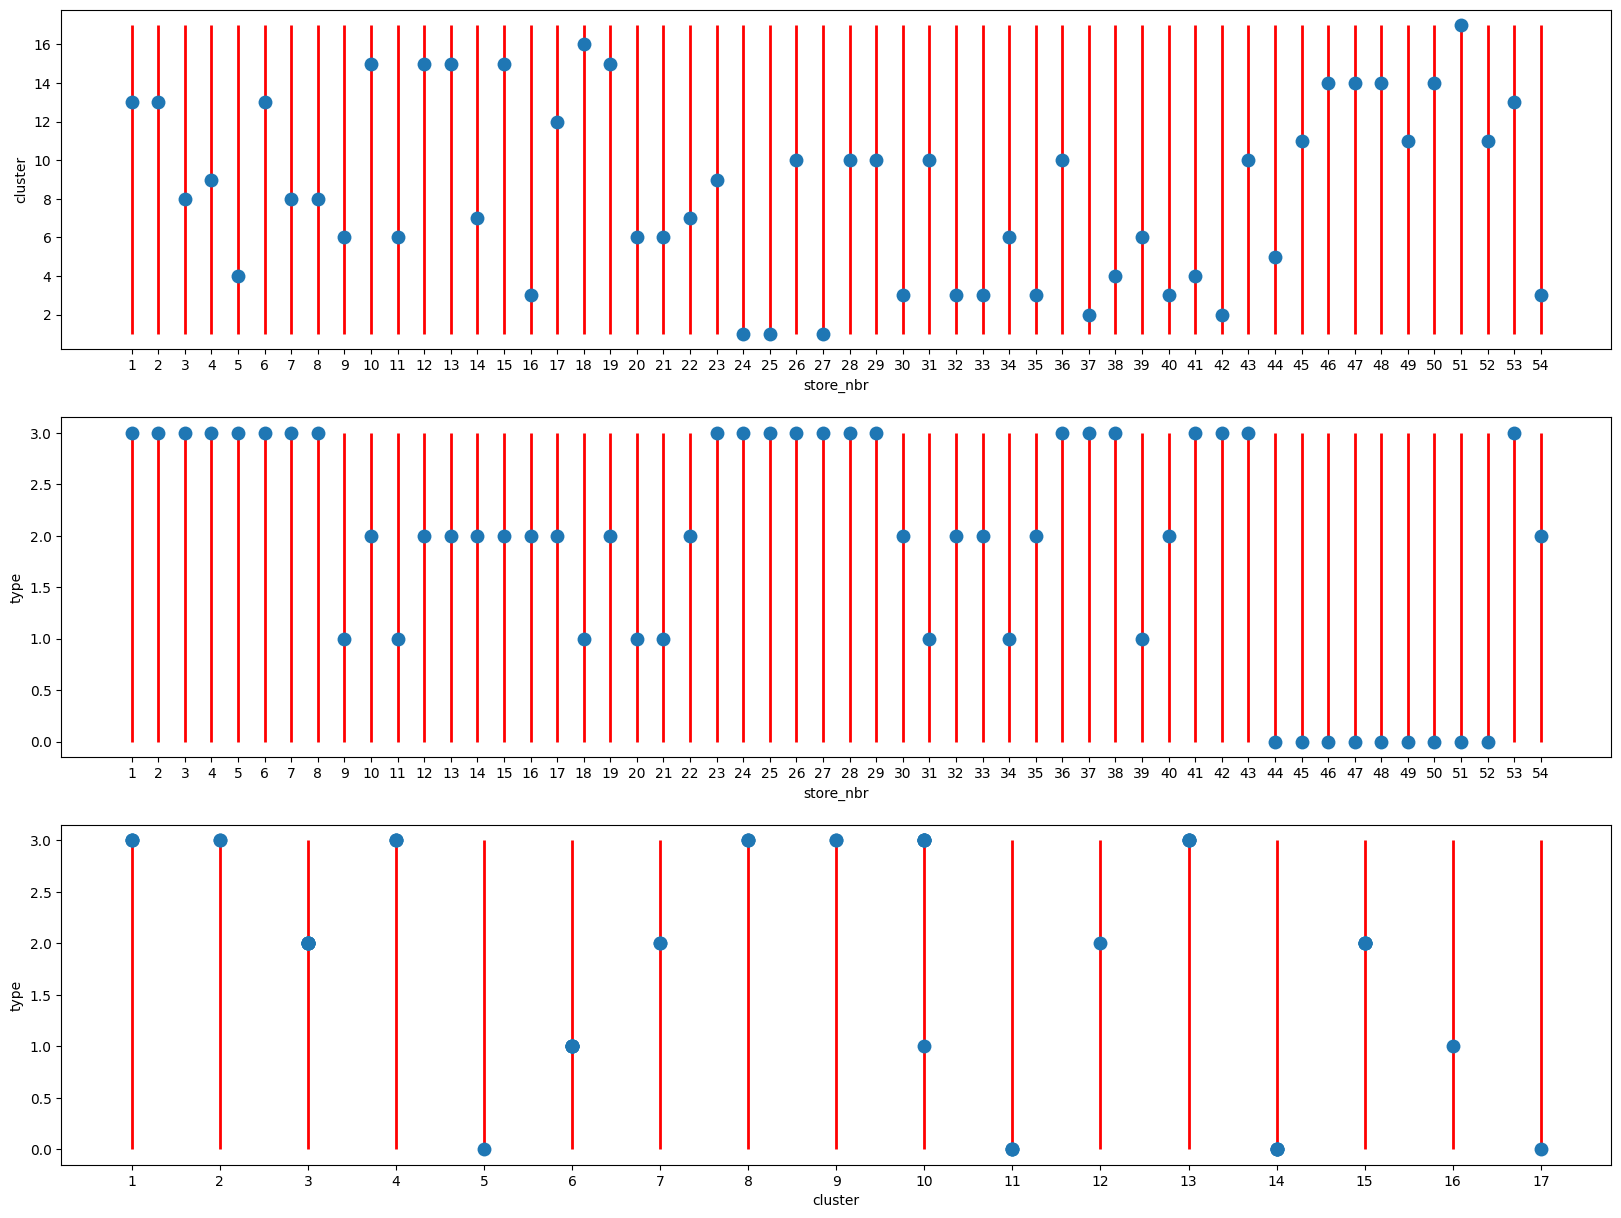

In [10]:
fig, axs = plt.subplots(3,1 , figsize = (20,15))

arr = np.arange(0,len(stores.store_nbr.unique()))

g = sns.stripplot(data=stores, x="store_nbr", y="cluster", jitter=False,  ax = axs[0], size = 10)
g.vlines(x=arr, ymin=stores.cluster.min(), ymax=stores.cluster.max(), ls='-', lw=2, color = 'red')

g = sns.stripplot(data=stores, x="store_nbr", y="type", jitter=False,  ax = axs[1], size = 10)
g.vlines(x=arr, ymin=stores.type.min(), ymax=stores.type.max(), ls='-', lw=2, color = 'red')

arr = np.arange(0,len(stores.cluster.unique()))
g = sns.stripplot(data=stores, x="cluster", y="type", jitter=False,  ax = axs[2] , size = 10)
g.vlines(x=arr, ymin=stores.type.min(), ymax=stores.type.max(), ls='-', lw=2, color = 'red')

plt.show()

**Observations**

* Each store_nbr belongs to a sepcific type

* Each store_nbr belongs to a specific cluster

* Each cluster belongs to  a specific type except cluster 10

# Zero Forecasting

In [11]:
# Though I'm not showing , believe me that all family are available at all store_type and cluster (I verified it)
# Let's see if any family is not sold at a particular store_nbr

df = df_data[:train.shape[0]].groupby(['store_nbr' , 'family']).agg({"sales" : "mean"}).reset_index().sort_values(by='sales')
df = df[df['sales']==0]
df

store_nbr           family  sales
1687         52            BOOKS    0.0
1141         35       LADIESWEAR    0.0
400          13            BOOKS    0.0
977          30  LAWN AND GARDEN    0.0
994          31            BOOKS    0.0
1060         33            BOOKS    0.0
1684         52        BABY CARE    0.0
598          19            BOOKS    0.0
514          16       LADIESWEAR    0.0
449          14  LAWN AND GARDEN    0.0
1126         35            BOOKS    0.0
1651         51        BABY CARE    0.0
697          22            BOOKS    0.0
1618         50        BABY CARE    0.0
1027         32            BOOKS    0.0
1585         49        BABY CARE    0.0
334          11            BOOKS    0.0
1093         34            BOOKS    0.0
1042         32       LADIESWEAR    0.0
1552         48        BABY CARE    0.0
532          17            BOOKS    0.0
1390         43            BOOKS    0.0
1519         47        BABY CARE    0.0
1405         43       LADIESWEAR    0.0
565          18            BOOKS    0.0
1486         46        BABY CARE    0.0
433          14            BOOKS    0.0
1075         33       LADIESWEAR    0.0
1453         45        BABY CARE    0.0
727          23        BABY CARE    0.0
1306         40       LADIESWEAR    0.0
397          13        BABY CARE    0.0
1420         44        BABY CARE    0.0
1159         36            BOOKS    0.0
466          15            BOOKS    0.0
1753         54            BOOKS    0.0
301          10            BOOKS    0.0
664          21            BOOKS    0.0
1291         40            BOOKS    0.0
268           9            BOOKS    0.0
1258         39            BOOKS    0.0
928          29            BOOKS    0.0
1768         54       LADIESWEAR    0.0
631          20            BOOKS    0.0
1769         54  LAWN AND GARDEN    0.0
895          28            BOOKS    0.0
910          28       LADIESWEAR    0.0
811          25       LADIESWEAR    0.0
1             1        BABY CARE    0.0
961          30            BOOKS    0.0
367          12            BOOKS    0.0
499          16            BOOKS    0.0
943          29       LADIESWEAR    0.0

**These stores never sold these products, hence we can do ZERO_PREDICTION for them for our horizon**

I also believe that informations like **city, state , cluster , type** may be needed while analysing impact of earthquake on sales

In [12]:
# Removing all rows from df_data with above combination of store-type and family-product

print('Before : ', df_data.shape)
for i in range(len(df)):
    store, family = df.iloc[i, 0] , df.iloc[i,1]
    df_data.drop(df_data[(df_data['store_nbr'] == store) &( df_data['family']==family)].index , inplace = True)

print('After : ', df_data.shape)

Before :  (3082860, 17)
After :  (2991170, 17)


 # Transaction (for each store)

**Observation**

**Transaction (last_date) < Train(last_date)  --->** again some missing data in transaction

In [13]:
df_data_ = df_data.groupby(["date", "store_nbr"]).sales.sum().reset_index()  # changing train to transaction format
df_data_.head()

date  store_nbr  sales
0 2013-01-01          1    0.0
1 2013-01-01          2    0.0
2 2013-01-01          3    0.0
3 2013-01-01          4    0.0
4 2013-01-01          5    0.0

In [14]:
train["date"] = pd.to_datetime(train.date)
transactions["date"] = pd.to_datetime(transactions.date)

train_ = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()  # changing train to transaction format
temp = pd.merge(train_, transactions, how = "inner")

print("Spearman Correlation between Total Sales and Transactions: {:,.4f}".format(temp.corr("spearman").loc["transactions", "sales"]))

Spearman Correlation between Total Sales and Transactions: 0.8175


In [15]:
px.line(transactions.sort_values(["store_nbr", "date"]), x=transactions.date, y='transactions', color='store_nbr',title = "Transactions" )

There is a stable pattern in Transaction. All months are similar except December from 2013 to 2017.

* **Store sales had always increased at the end of the year.**

* Let's take a look at transactions by **using monthly average sales!**

We've just learned a pattern what increases sales. It was the end of the year. We can see that transactions increase in spring and decrease after spring.

In [16]:
transactions.set_index('date' , inplace = True)
a = transactions.resample("M").transactions.mean().reset_index()    # reset_index : changed from dateTimeIndex
a["year"] = a.date.dt.year
print('Rest of 2017 data is in test set')
px.line(a, x='date', y='transactions', color='year',title = "Monthly Average Transactions")

Rest of 2017 data is in test set


In [17]:
a = transactions.copy().reset_index()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()
px.line(a, x="dayofweek", y="transactions" , color = "year", title = "Transactions")

In [18]:
px.scatter(temp, x = "transactions", y = "sales", trendline = "ols", trendline_color_override = "red")

In [19]:
if np.isnan(df_data['transactions'].iloc[0]):
    df_data.loc[0,'transactions'] = df_data.loc[df_data['transactions'].first_valid_index(),'transactions']  # update with recent non-nan value

df_data['transactions'] = df_data['transactions'].interpolate(limit_direction='forward') 

df_data.head(2)

id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   

  store_type  cluster  dcoilwtico  transactions holiday_type    locale  \
0          D       13       93.14         770.0      Holiday  National   
2          D       13       93.14         770.0      Holiday  National   

  locale_name         description  transferred  
0     Ecuador  Primer dia del ano        False  
2     Ecuador  Primer dia del ano        False

# Analysing Stores and Family Products

In [20]:
df_store_type = df_data[:train.shape[0]].groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_family = df_data[:train.shape[0]].groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_cluster = df_data[:train.shape[0]].groupby('cluster').agg({"sales" : "mean"}).reset_index() 

# chart color
df_store_type['color'] = '#496595'
df_family['color'] = '#c6ccd8'
df_cluster['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Top 10 Highest Product Sales", "Highest Sales in Stores", "Clusters Vs Sales"))

fig.add_trace(go.Bar(x=df_family['sales'], y=df_family['family'], marker=dict(color= df_family['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_store_type['sales'], labels=df_store_type['store_type'], name='Store type',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
fig.add_trace(go.Bar(x=df_cluster['cluster'], y=df_cluster['sales'], 
                     marker=dict(color= df_cluster['color']), name='Cluster'), 
                     row=2, col=1)

# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_cluster.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

# Analysing Sales 

* Segmenting a year on different time-spans (months, quarters, week of year)

In [21]:
df_data['year'] = df_data['date'].dt.year
df_data['month'] = df_data['date'].dt.month
df_data['week'] = df_data['date'].dt.isocalendar().week
df_data['quarter'] = df_data['date'].dt.quarter
df_data['day_of_week'] = df_data['date'].dt.day_name()

df_data.head(2)

id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   

  store_type  cluster  ...  holiday_type    locale locale_name  \
0          D       13  ...       Holiday  National     Ecuador   
2          D       13  ...       Holiday  National     Ecuador   

          description transferred  year  month  week  quarter  day_of_week  
0  Primer dia del ano       False  2013      1     1        1      Tuesday  
2  Primer dia del ano       False  2013      1     1        1      Tuesday  

[2 rows x 22 columns]

In [22]:
# monthly-data
df_m = df_data.loc[:train.shape[0]].groupby('month').agg({"sales" : "mean"}).reset_index()
df_m['sales'] = round(df_m['sales'],2)
df_m['month_text'] = df_m['month'].apply(lambda x: calendar.month_abbr[x])
df_m['text'] = df_m['month_text'] + ' - ' + df_m['sales'].astype(str) 

# weekly, quarterly data
df_w = df_data.loc[:train.shape[0]].groupby('week').agg({"sales" : "mean"}).reset_index() 
df_q = df_data.loc[:train.shape[0]].groupby('quarter').agg({"sales" : "mean"}).reset_index() 
# chart color
df_m['color'] = '#496595'
df_m['color'].loc[:-1] = '#c6ccd8'
df_w['color'] = '#c6ccd8'

# chart ---------------------------------------------------------------------------------------
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Avg Sales Analysis", 
                                    "Week wise Avg Sales Analysis"))

fig.add_trace(go.Bar(x=df_m['sales'], y=df_m['month'], marker=dict(color= df_m['color']),
                     text=df_m['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q['sales'], labels=df_q['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w['week'], y=df_w['sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling -----------------------------------------------------------------------------------------
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

/tmp/ipykernel_47/1507135960.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
avg_sales = df_data[df_data.date < '2017-08-16'].groupby(['date']).agg({'sales': 'mean'})
avg_sales.head(2)

sales
date                  
2013-01-01    1.452643
2013-01-02  286.924475

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

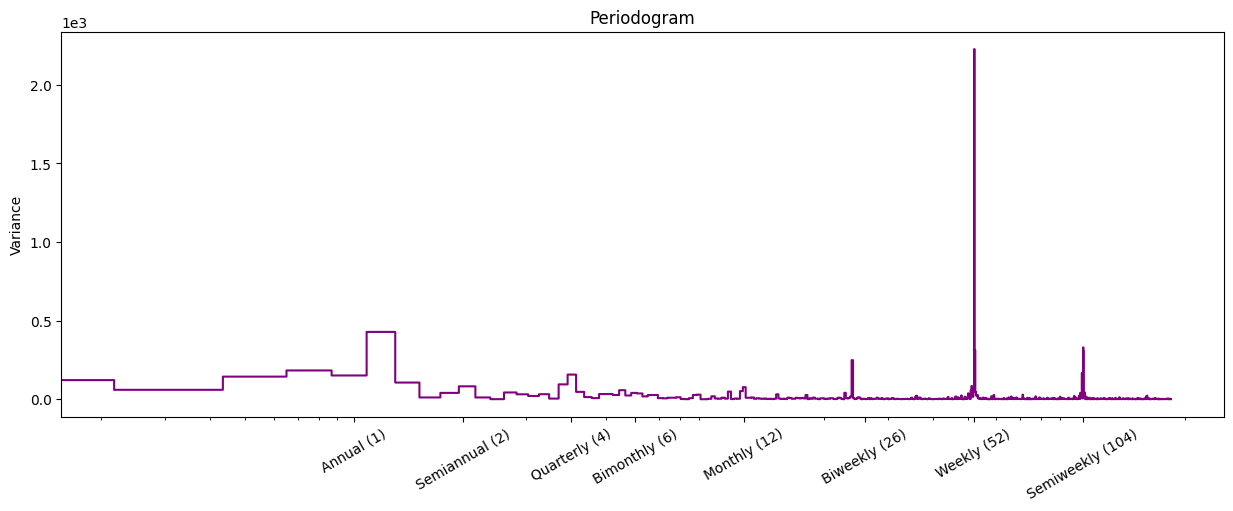

In [24]:
# Periodogram Analysis

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = 365.2425
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,   # frequency of sampling of ts (here, 1 day)
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize = (15,5))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(avg_sales.squeeze())

* The periodogram shows very strong weekly seasonality

# Decomposition into (Trend, Seasonality, Residual)

* The additive model is Y[t] = T[t] + S[t] + e[t]

Text(0, 0.5, 'Residual')

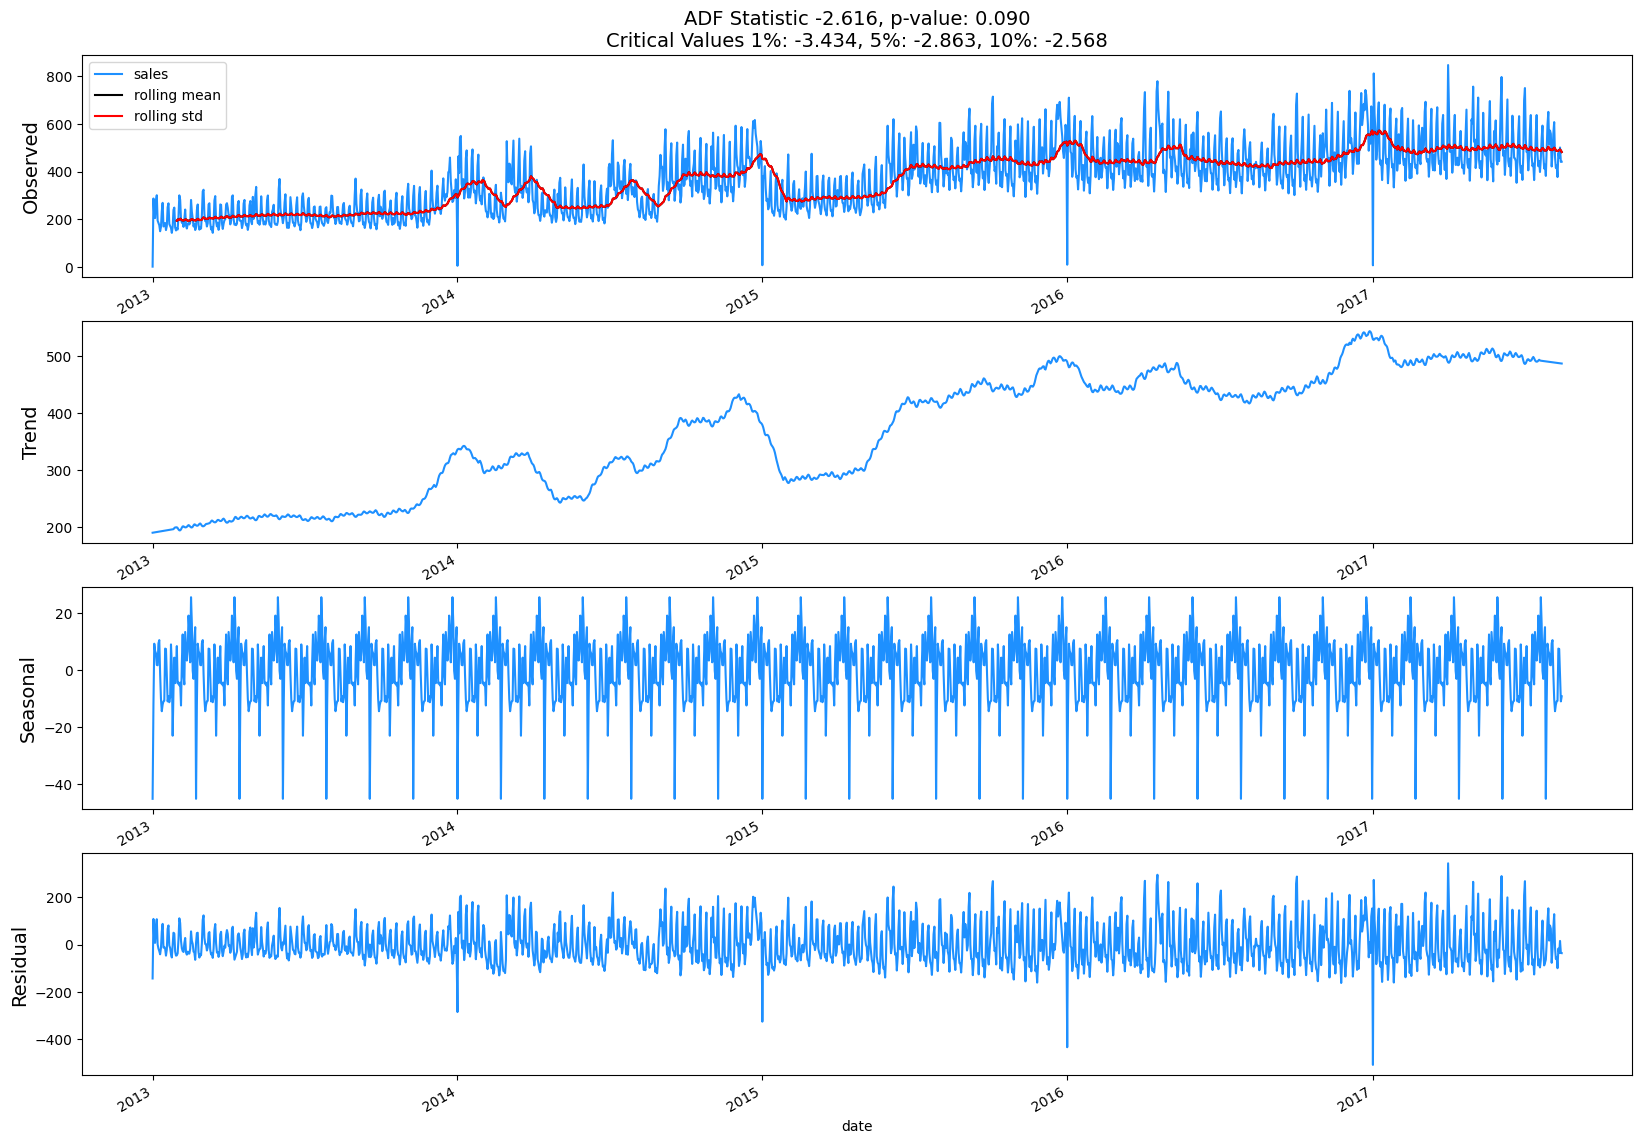

In [25]:
df_tr = avg_sales

res = seasonal_decompose(df_tr.sales,period = 52, model='additive', extrapolate_trend='freq')

result = adfuller(df_tr.sales)
significance_level = 0.05
adf_stat = result[0]
p_val, crit_val_1, crit_val_5, crit_val_10 = result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']

fig, ax = plt.subplots(4,1 ,figsize = (20,15))
ax[0].set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

sns.lineplot(x=df_tr.index, y=df_tr['sales'].rolling(30).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df_tr.index, y=df_tr['sales'].rolling(30).mean(), ax=ax[0], color='red', label='rolling std')

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

The series is not stationary, we can check that through observation --

* Presence of trend, seasonality

* p_value>0.05,  ADF_statistic not very large negative no.

* non-constant mean, std (both overlap, fig-0)

# Lag Analysis

* Except **sales** we have **oil, transaction** as other 2 numerical features

* **Transactions**  are already moving in-phase with **sales**

* The effects on **oil price** today will affect the **sales** in near future, hence analysing lag-shift for it

In [26]:
# Lets try shifting oil-price at-max 1week in future (due to strong weekly seasonality)
# to check for whether it can come in-phase or out-phase with sales price

df_oil_sales = df_data[df_data['date']< '2017-08-16'].groupby(['date']).agg({'dcoilwtico': 'mean', })
for i in range(-60,61):
    X= df_oil_sales.dcoilwtico.shift(i)
    df_concat = pd.merge(X, avg_sales, how='inner',on = avg_sales.index )
    print("Spearman Correlation lag={i}day : {x:,.4}".format(i=i,x= df_concat.corr("spearman").iloc[0,1]))

Spearman Correlation lag=-60day : -0.7404
Spearman Correlation lag=-59day : -0.7404
Spearman Correlation lag=-58day : -0.7404
Spearman Correlation lag=-57day : -0.7405
Spearman Correlation lag=-56day : -0.7405
Spearman Correlation lag=-55day : -0.7406
Spearman Correlation lag=-54day : -0.7406
Spearman Correlation lag=-53day : -0.7406
Spearman Correlation lag=-52day : -0.7407
Spearman Correlation lag=-51day : -0.7407
Spearman Correlation lag=-50day : -0.7408
Spearman Correlation lag=-49day : -0.741
Spearman Correlation lag=-48day : -0.7411
Spearman Correlation lag=-47day : -0.7412
Spearman Correlation lag=-46day : -0.7414
Spearman Correlation lag=-45day : -0.7415
Spearman Correlation lag=-44day : -0.7416
Spearman Correlation lag=-43day : -0.7418
Spearman Correlation lag=-42day : -0.7419
Spearman Correlation lag=-41day : -0.7421
Spearman Correlation lag=-40day : -0.7422
Spearman Correlation lag=-39day : -0.7423
Spearman Correlation lag=-38day : -0.7424
Spearman Correlation lag=-37day : -

* We can see that shifting oil_prices (+/-) 1 month is not affecting the correlation, this means that there is very small oil_price fluctuation wrt sales fluctuations (i.e., **the government is able to maintain stable oil price in general**)

* Though all correlations are (-ve) which agrees with reality

# Label-Encoding

In [27]:
non_numerical_cols =  [col for col in df_data.columns if df_data[col].dtype == 'object']
for feature in non_numerical_cols:        
    df_data[feature] = LabelEncoder().fit_transform(df_data[feature])
df_data.head().style.set_properties(subset=non_numerical_cols, **{'background-color': '#F1C40F'})


In [28]:
low_cardinality_cols = [col for col in non_numerical_cols if len(df_data[col].unique()) < 15]
df_data.head().style.set_properties(subset=low_cardinality_cols, **{'background-color': '#F1C40F'})

In [29]:
encoded_features = []

for feature in low_cardinality_cols:
    if feature == 'store_type' or feature == 'holiday_type':
        continue
    encoded_feat = OneHotEncoder().fit_transform(df_data[feature].values.reshape(-1, 1)).toarray()
    n = df_data[feature].nunique()
    df_data.drop(columns = [feature], inplace= True)
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df_data.index
    df_data = pd.concat([df_data, encoded_df], axis=1)


df_data.head()

id       date  store_nbr  family  sales  onpromotion  city  state  \
0   0 2013-01-01          1       0    0.0            0    18     12   
2   2 2013-01-01          1       2    0.0            0    18     12   
3   3 2013-01-01          1       3    0.0            0    18     12   
4   4 2013-01-01          1       4    0.0            0    18     12   
5   5 2013-01-01          1       5    0.0            0    18     12   

   store_type  cluster  ...  locale_2  locale_3  locale_4  day_of_week_1  \
0           3       13  ...       0.0       1.0       0.0            0.0   
2           3       13  ...       0.0       1.0       0.0            0.0   
3           3       13  ...       0.0       1.0       0.0            0.0   
4           3       13  ...       0.0       1.0       0.0            0.0   
5           3       13  ...       0.0       1.0       0.0            0.0   

   day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  \
0            0.0            0.0            0.0            0.0            1.0   
2            0.0            0.0            0.0            0.0            1.0   
3            0.0            0.0            0.0            0.0            1.0   
4            0.0            0.0            0.0            0.0            1.0   
5            0.0            0.0            0.0            0.0            1.0   

   day_of_week_7  
0            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  

[5 rows x 31 columns]

# Cross Validation

* For cross validation, you can use the Time Series Split library.

* shuffling in cross validator is inappropriate.

* In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

* Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

In [30]:
df_test = df_data[df_data.date >= '2017-08-16']
df_test.drop(columns = ['sales'], inplace = True)

df_train = df_data[df_data.date < '2017-08-16']
df_train.drop('id' , inplace = True, axis=1)
df_train.head()

/tmp/ipykernel_47/2129336100.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_47/2129336100.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



date  store_nbr  family  sales  onpromotion  city  state  store_type  \
0 2013-01-01          1       0    0.0            0    18     12           3   
2 2013-01-01          1       2    0.0            0    18     12           3   
3 2013-01-01          1       3    0.0            0    18     12           3   
4 2013-01-01          1       4    0.0            0    18     12           3   
5 2013-01-01          1       5    0.0            0    18     12           3   

   cluster  dcoilwtico  ...  locale_2  locale_3  locale_4  day_of_week_1  \
0       13       93.14  ...       0.0       1.0       0.0            0.0   
2       13       93.14  ...       0.0       1.0       0.0            0.0   
3       13       93.14  ...       0.0       1.0       0.0            0.0   
4       13       93.14  ...       0.0       1.0       0.0            0.0   
5       13       93.14  ...       0.0       1.0       0.0            0.0   

   day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  \
0            0.0            0.0            0.0            0.0            1.0   
2            0.0            0.0            0.0            0.0            1.0   
3            0.0            0.0            0.0            0.0            1.0   
4            0.0            0.0            0.0            0.0            1.0   
5            0.0            0.0            0.0            0.0            1.0   

   day_of_week_7  
0            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  

[5 rows x 30 columns]

In [31]:
N_SPLITS = 3

Y = avg_sales.reset_index(drop = True)
X = avg_sales.index

folds = TimeSeriesSplit(n_splits=N_SPLITS)

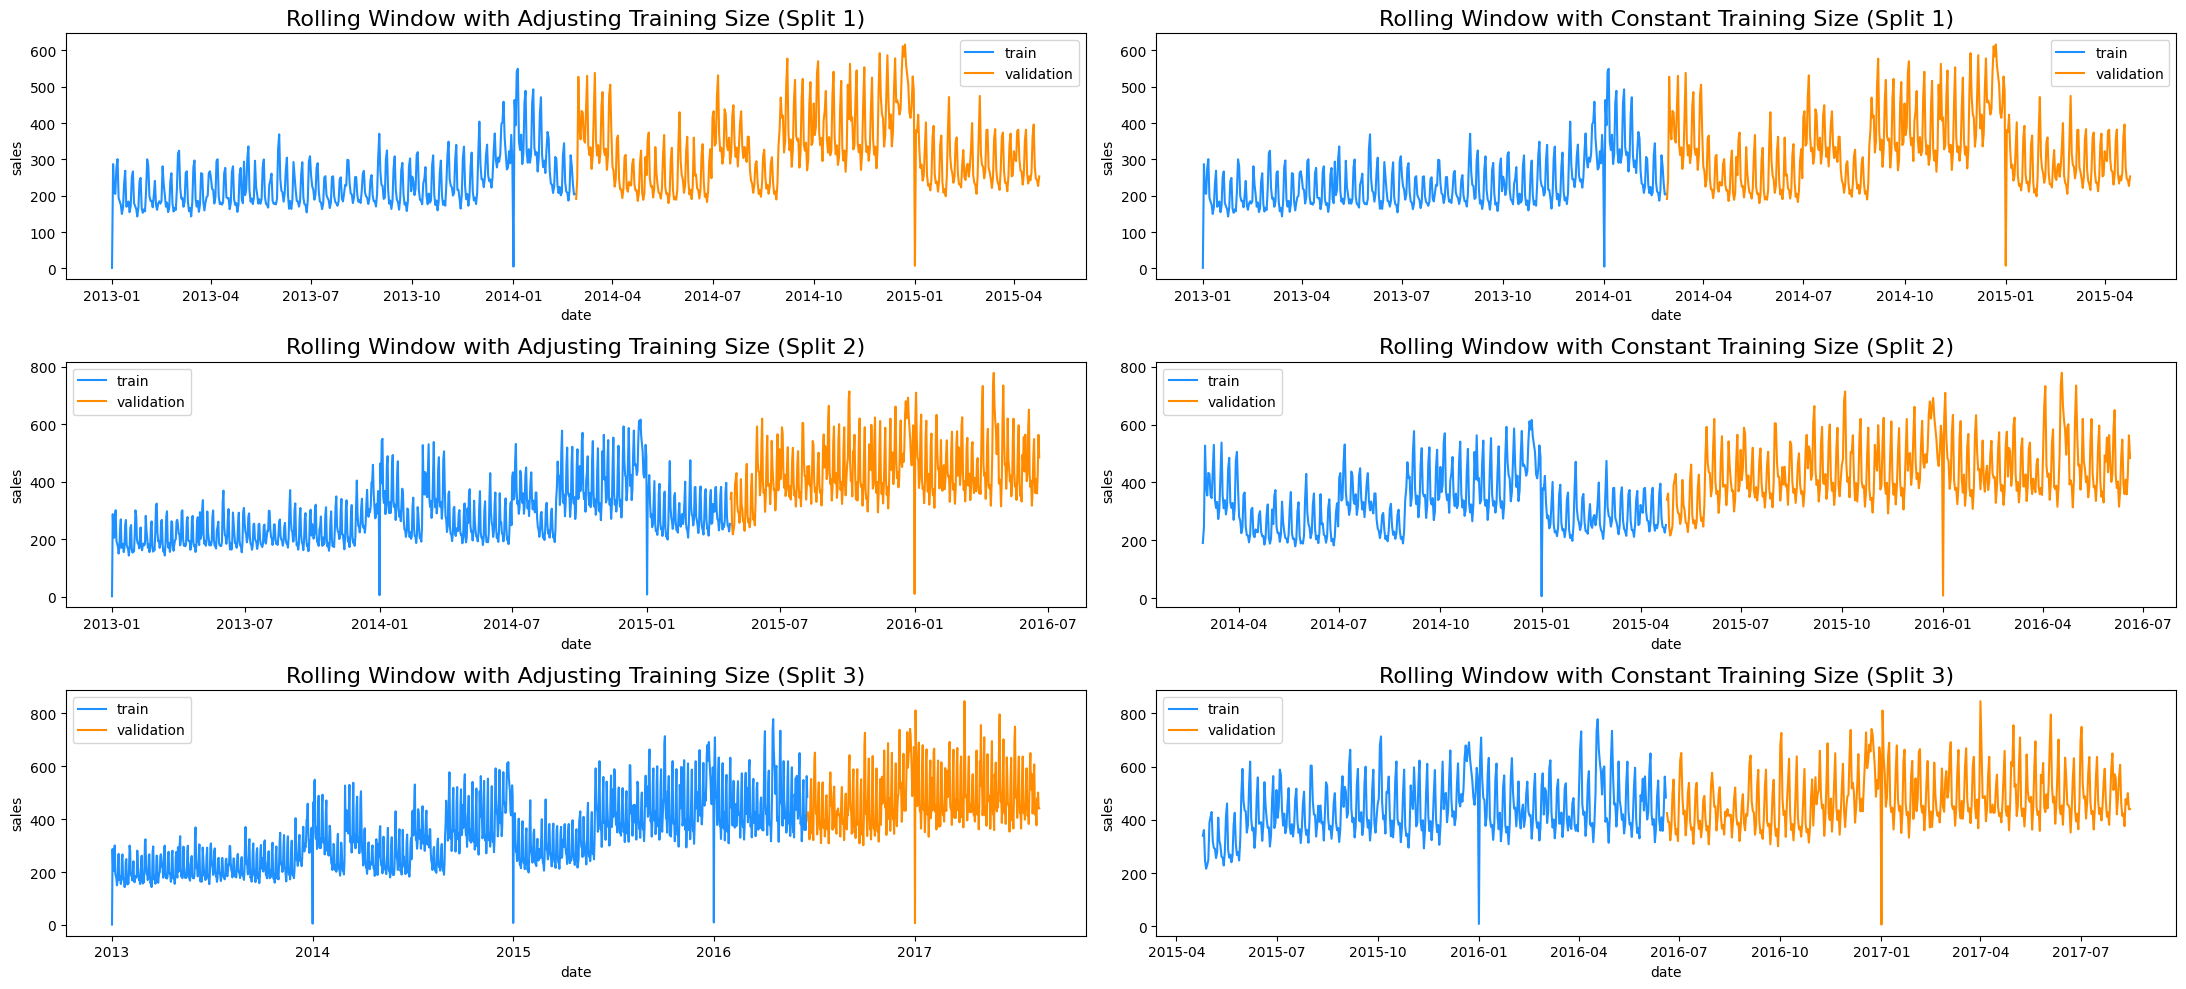

In [32]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(22, 10))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = Y.iloc[train_index ,0], Y.iloc[valid_index, 0]
    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

plt.tight_layout()
plt.show()

* There is no overlap over valid regions in different folds

* The default is Adjusting Training Data

# Using SARIMA 

* There is strong weekly seasonality 
* There is also trend development as can be seen from series decomposition
* Length of cycle : 1 week (see decomposition of sales)
* m : 7 (frequency of observation in cycle length)
* D : order of seasonal differencing

# Finding Differencing Order
* To use ARIMA model, we need to find order of differencing which makes series stationary

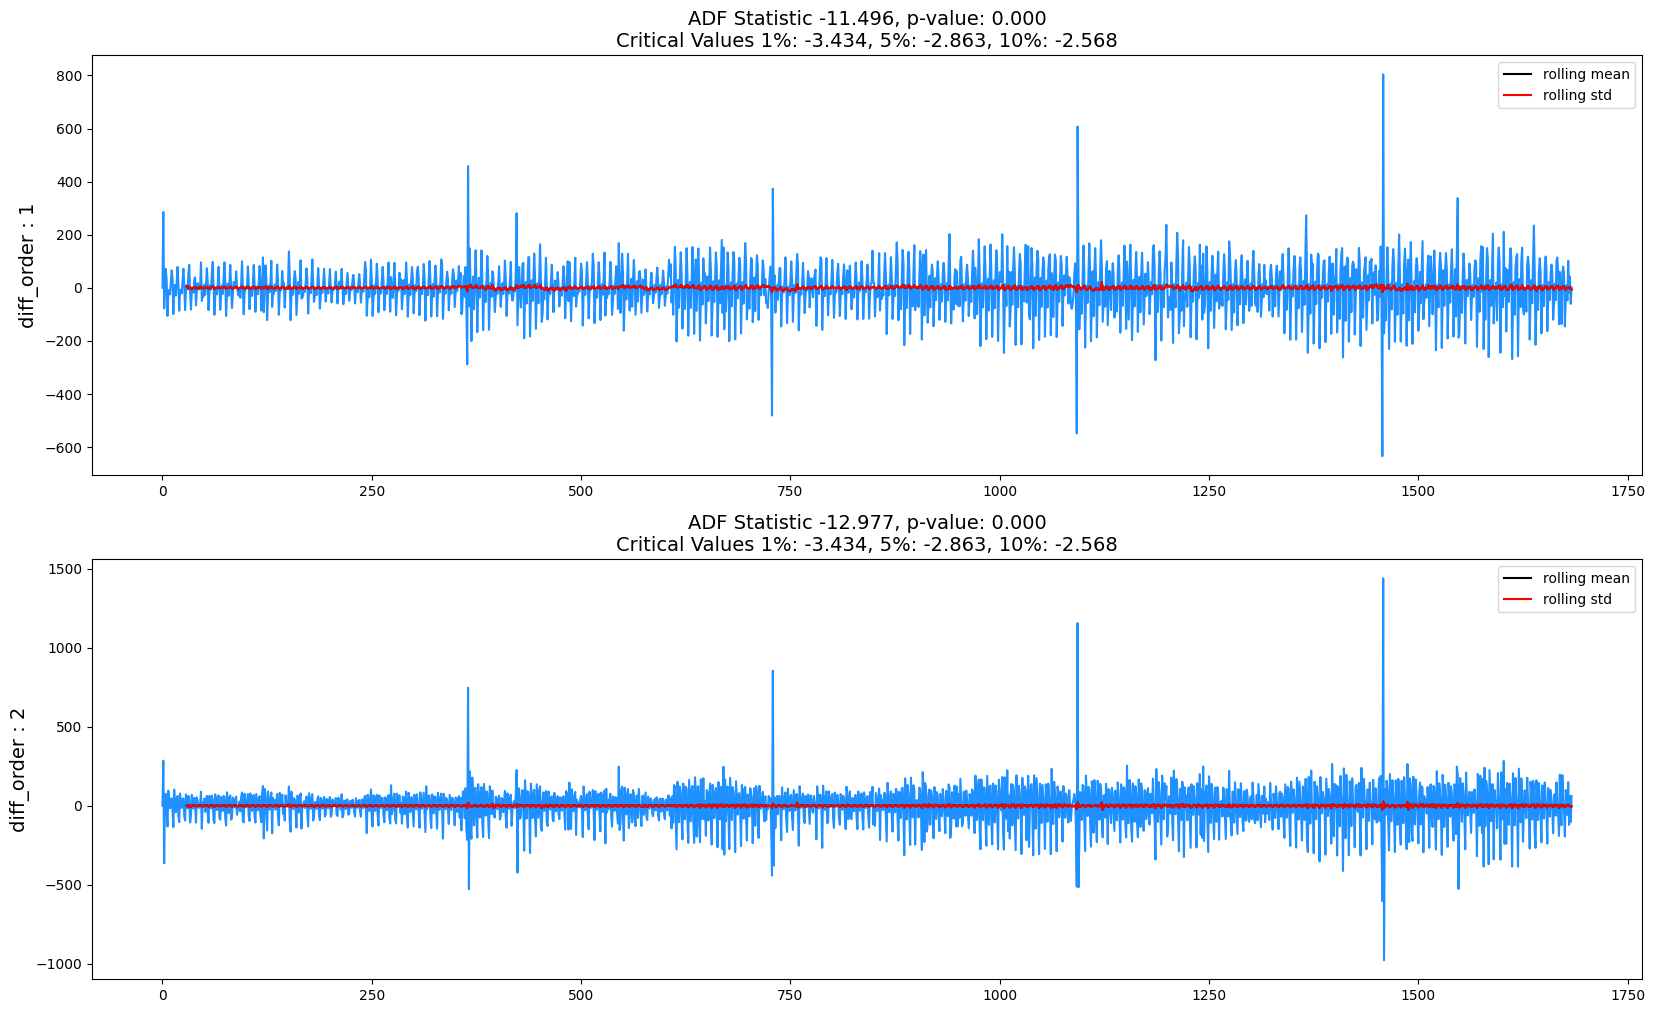

In [33]:
y = pd.DataFrame(Y, columns = ['sales'])

# First Order Differencing
ts_diff = np.diff(y.sales)
y['sales_diff_1'] = np.append([0], ts_diff)  # compensating loss of 1st data-point with 0

# Second Order Differencing
ts_diff = np.diff(y.sales_diff_1)
y['sales_diff_2'] = np.append([0], ts_diff)

fig, ax = plt.subplots(2,1 ,figsize = (20,12))
def check_stationarity(df, col, axs, order):

    result = adfuller(df.loc[:,col])
    significance_level = 0.05
    adf_stat = result[0]
    p_val, crit_val_1, crit_val_5, crit_val_10 = result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']

    ax[axs].set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax[axs].plot(df.index , df[col], color='dodgerblue')
    ax[axs].set_ylabel('diff_order : {x}'.format(x = order), fontsize=14)

    sns.lineplot(x=df.index, y=df[col].rolling(30).mean(), ax=ax[axs], color='black', label='rolling mean')
    sns.lineplot(x=df.index, y=df[col].rolling(30).mean(), ax=ax[axs], color='red', label='rolling std')

check_stationarity(y, 'sales_diff_1', 0, 1)
check_stationarity(y, 'sales_diff_2', 1, 2)

* For d=1, the series becomes stationary visually and statitically

* These needles in figure are indicating high sales at the end of each year(near Christmas) which reiterate our observations made above

* I am saying so as the differencing is not able to bring it near 0 , this means that there's a sudden un-natural jump in sales

* Now we can do model building

# Seasonal Order Of Differencing

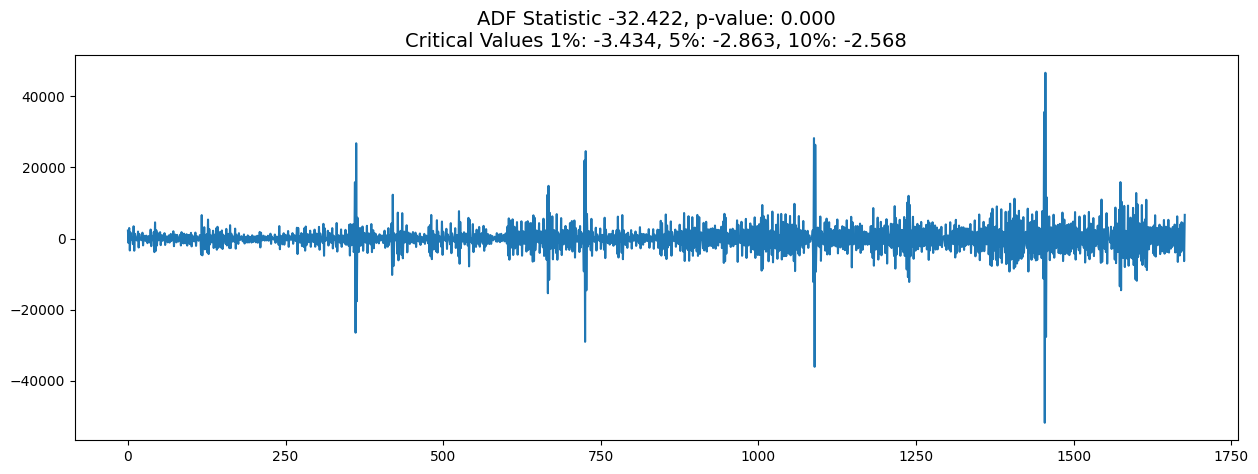

In [34]:
m = 7

df_diff_seasonal_diff = np.diff(y.sales_diff_1, n=m)
result = adfuller(df_diff_seasonal_diff)
significance_level = 0.05
adf_stat = result[0]
p_val, crit_val_1, crit_val_5, crit_val_10 = result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']
plt.figure(figsize = (15,5))
x = np.arange(0, len(df_diff_seasonal_diff))
plt.plot(x, df_diff_seasonal_diff)
plt.title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
plt.show()

# ACF, PACF Analysis

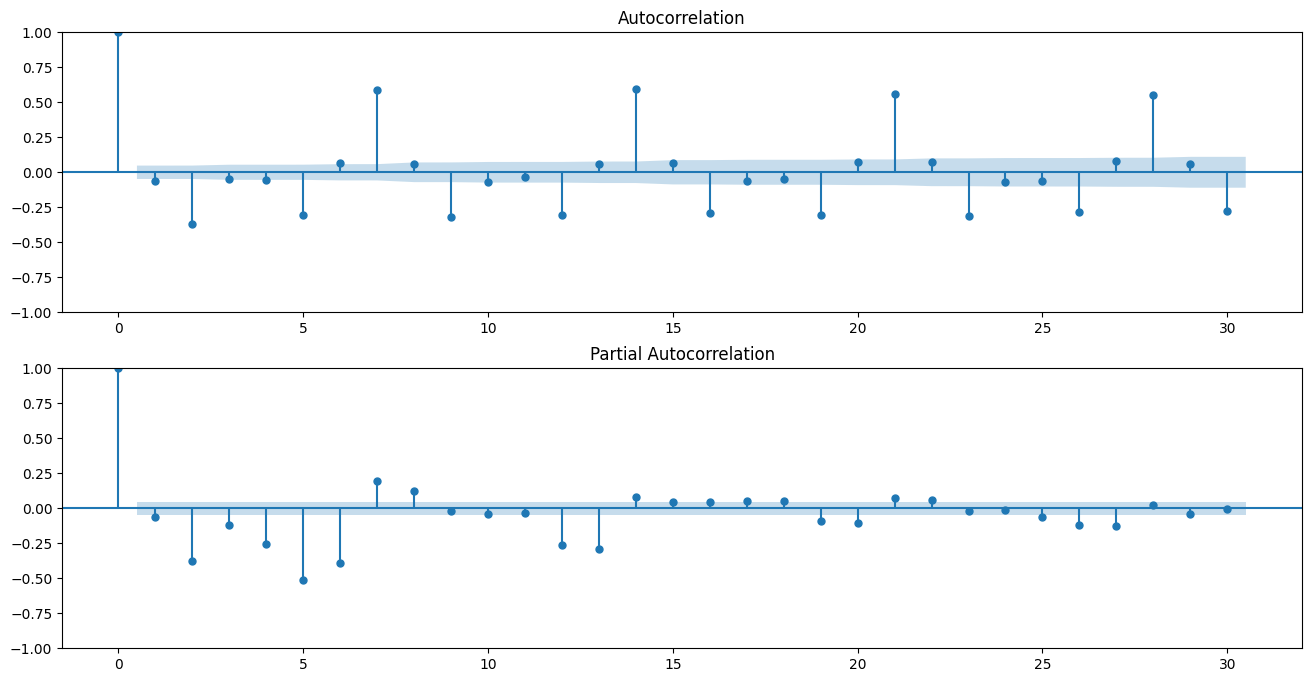

In [35]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(y.sales_diff_1,lags=30, ax=ax[0])
plot_pacf(y.sales_diff_1,lags=30, ax=ax[1])
plt.show()

* The time-series is not purely AR since PACF doesn't drop suddenly
* Not purely MA since ACF doesn't drop suddenly
* Hence we can't estimate (p,q) graphically and need to create a search space for them

In [36]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d:int, D: int, s: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog,order=(order[0], d, order[1]),seasonal_order=(order[2], D, order[3], s),simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,q,P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df

In [37]:
X_tr = None
X_val = None
for i, (train_index, valid_index) in enumerate(folds.split(Y)):   # returns ndarray
    X_tr, X_val = Y.iloc[train_index],Y.iloc[valid_index]

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))
d = 1
D = 1
s = 7

X_tr.index = pd.DatetimeIndex(X_tr.index).to_period('W')
# SARIMA_result_df = optimize_SARIMA(X_tr, SARIMA_order_list, d, D, s)
# SARIMA_result_df.head()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



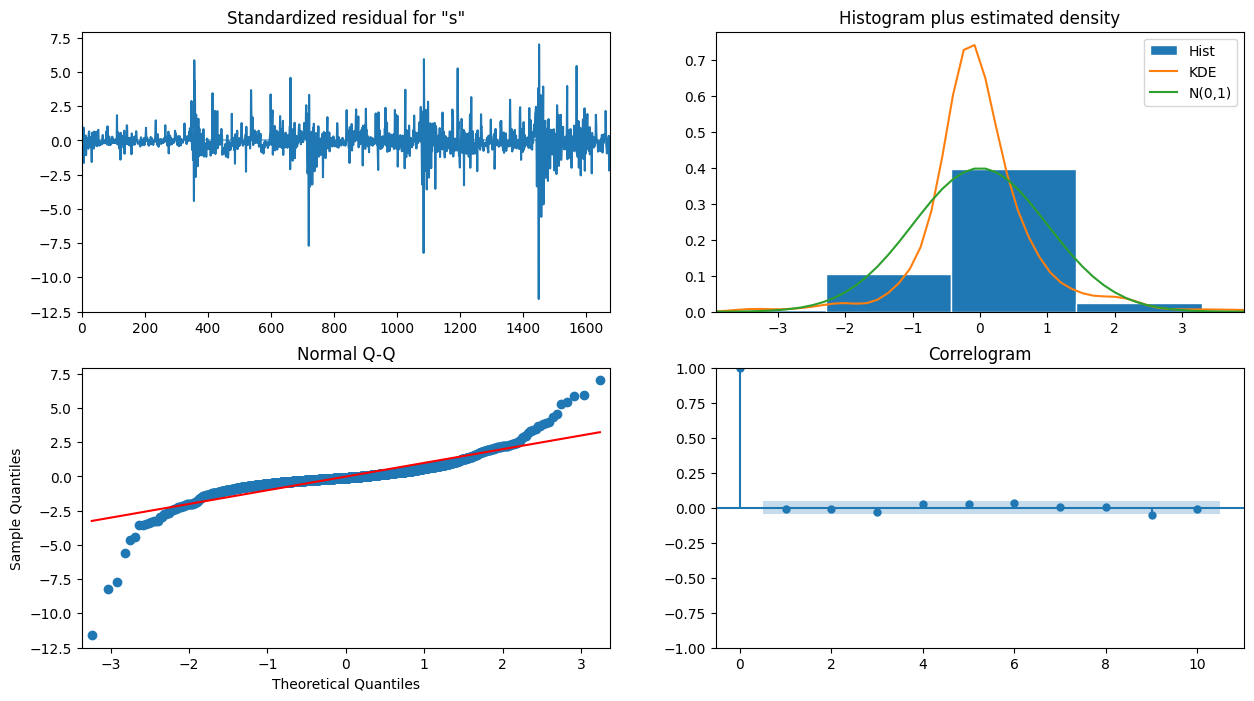

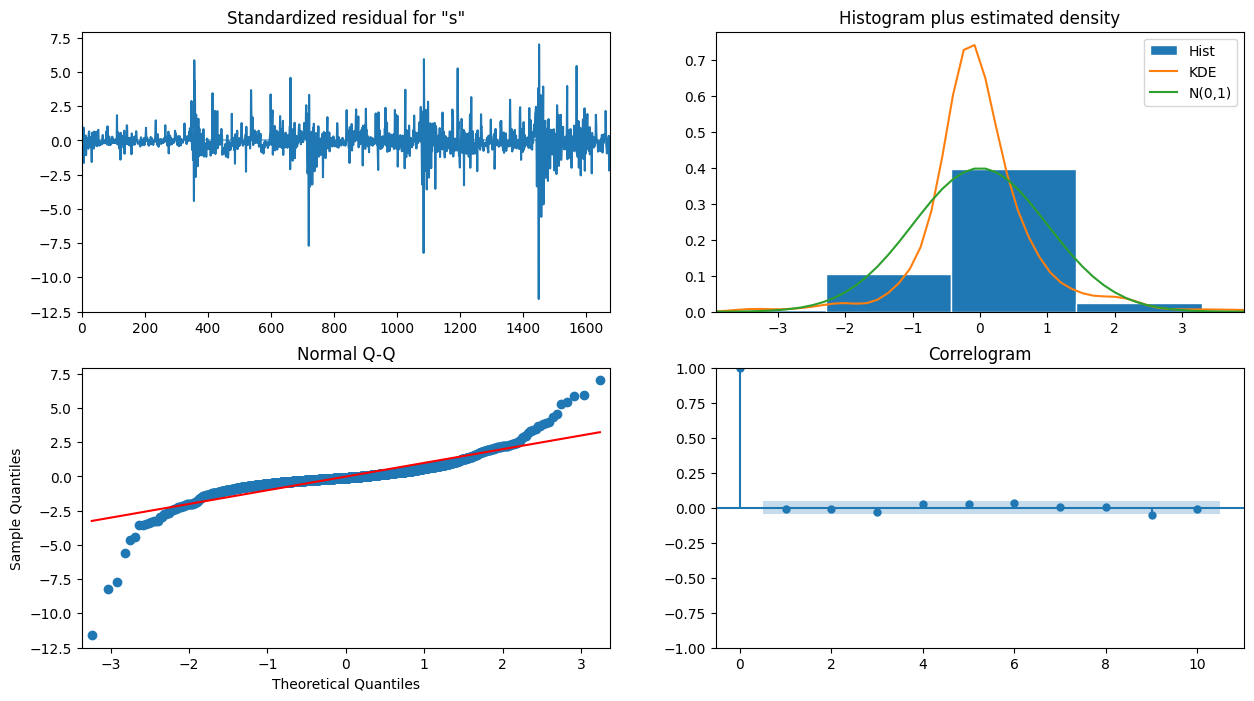

In [38]:
p,q,P, Q = 3,1,2,1
sarima_model = SARIMAX(avg_sales.sales,order=(p, d,q),seasonal_order=(P, D, Q, s), simple_differencing=False)
model_fit = sarima_model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(15,8))

In [39]:
residuals = model_fit.resid
df = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)

df.lb_pvalue

1     0.691149
2     0.915727
3     0.679719
4     0.577691
5     0.586619
6     0.408613
7     0.511398
8     0.614693
9     0.306092
10    0.383146
Name: lb_pvalue, dtype: float64

* The returned p-values are all greater than 0.05. 
* Therefore, we do not reject the nullhypothesis, and we conclude that the residuals are independent and uncorrelated, just like white noise.

In [40]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

SARIMA_pred = model_fit.get_prediction(0,1683).predicted_mean
mape_SARIMA = mape(avg_sales.sales, SARIMA_pred)
print('MAPE (SARIMA) : {x:.4f}'.format(x = mape_SARIMA))
print('RMSLE (SARIMA) : {x:.4f}'.format(x = mean_squared_error(avg_sales.sales, SARIMA_pred , squared=False)))

MAPE (SARIMA) : 23.5303
RMSLE (SARIMA) : 57.0317


# XG BOOST

* For correcting the mistakes made by SARIMA in predicting time-series

In [41]:
# df_train.set_index('date', inplace = True)
Y = df_train.loc[:, ['date', 'sales']]
Y.set_index('date', inplace = True)
Y = pd.DataFrame(Y, columns = ['sales'])
SARIMA_pred_ = pd.DataFrame(SARIMA_pred )

SARIMA_pred_.head(2)

predicted_mean
date                      
2013-01-01         0.00000
2013-01-02         1.45117

In [42]:
def get_pred(date) : 
    return SARIMA_pred_[SARIMA_pred_.index == date].predicted_mean[0]

Y['SARIMA_PRED'] = Y.index.map(lambda x : get_pred(x))
Y.head()

sales  SARIMA_PRED
date                          
2013-01-01    0.0          0.0
2013-01-01    0.0          0.0
2013-01-01    0.0          0.0
2013-01-01    0.0          0.0
2013-01-01    0.0          0.0

In [43]:
Y['SARIMA_RESIDUE'] = Y['sales'] - Y['SARIMA_PRED']
Y.tail(3)

sales  SARIMA_PRED  SARIMA_RESIDUE
date                                             
2017-08-15  2419.729   423.840232     1995.888768
2017-08-15   121.000   423.840232     -302.840232
2017-08-15    16.000   423.840232     -407.840232

In [89]:
X_xg = df_train.drop(['sales', 'date'], axis=1)
X_xg['week'] = X_xg['week'].astype('int64')
Y_xg = Y['SARIMA_RESIDUE']

model_xgb = XGBRegressor(n_estimators=10000, max_depth=7, eta=0.1)
model_xgb.fit(X_xg, Y_xg)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
xgb_pred = model_xgb.predict(X_xg)

Y['Final Pred'] = Y['SARIMA_PRED'] + xgb_pred
Y.tail()

In [ ]:
print('MAPE (XGB+SARIMA) : {x:.4f}'.format(x = mape(Y['sales'] , Y['Final Pred'])))
print('RMSLE (XGB+SARIMA) : {x:.4f}'.format(x = mean_squared_error(Y['sales'] , Y['Final Pred'] , squared=False)))

In [ ]:
grouped_final_pred = Y.groupby(['date']).aggregate({'Final Pred': 'mean'})
print('Averaged over day metrics : ')
print('MAPE (XGB+SARIMA) : {x:.4f}'.format(x = mape(avg_sales.sales , grouped_final_pred['Final Pred'])))
print('RMSLE (XGB+SARIMA) : {x:.4f}'.format(x = mean_squared_error(avg_sales.sales , grouped_final_pred , squared=False)))

* We see a drastic downfall in both the metrics (MAPE, RMSE) after applying xg-boost, 
* hence we can expect to see good perfomance on test set with this Hybrid (SARIMA + XGBoost) and Zero ForeCasting

# ForeCasting 

In [ ]:
df_test['week'] = df_test['week'].astype('int64')
forecast_df = pd.DataFrame(df_test['id'])
forecast_df

In [ ]:
# forecast_df.set_index('date', inplace = True)
df_test.drop('id' , inplace = True, axis =1)
s = '2017-08-'
dates = [s+str(x) for x in range(16,32)]
sarima_forecast = model_fit.get_prediction(1117 , 1132).predicted_mean.reset_index(drop = True)

f = pd.DataFrame(sarima_forecast)
f['date'] = dates
pd.to_datetime(f.date)
f.set_index('date', inplace = True)
f

In [ ]:
def get_pred(date ) :
    x =  f[f.index == date ].iloc[0][0]
    return x

f.index=f.index.astype(str)
forecast_df.index=forecast_df.index.astype(str)

forecast_df['SARIMA_PRED'] = forecast_df.index.map(lambda x : get_pred(x))
forecast_df.head()

# Submission

In [ ]:
df_submit = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

def f(id):
    if forecast_df[forecast_df['id'] == id]
    

df_submit['sales'] = df_submit.id.map(lambda x : f(x))